In [52]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, precision_recall_curve, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

In [53]:
# Configuration
DATA_PATH = "diabetic_data.csv"    
TARGET_COL = "readmitted"          # Target column
TIME_COL = None                   
ID_COL = "encounter_id"          

In [54]:
# Load and clean dataset
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape, "rows and columns")
# Drop IDs and patient number
df.drop(columns=[ID_COL, "patient_nbr"], errors="ignore", inplace=True)
# Convert target to binary (1 = readmitted, 0 = not)
df[TARGET_COL] = df[TARGET_COL].replace({">30": 1, "<30": 1, "NO": 0}).astype(int)
# Replace '?' with NaN
df = df.replace("?", np.nan)

Loaded: (101766, 50) rows and columns


C:\Users\dell\AppData\Local\Temp\ipykernel_10232\3794673602.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[TARGET_COL] = df[TARGET_COL].replace({">30": 1, "<30": 1, "NO": 0}).astype(int)


In [55]:
# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=["number"]).columns.drop(TARGET_COL, errors="ignore").tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numeric columns: 11
Categorical columns: 36


In [56]:
# Advanced Imputation and Preprocessing (Final Version)
# - Numeric columns: KNNImputer → fills missing values using similar patients
# - Categorical columns: SimpleImputer → fills missing using most common value

numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights='uniform')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine both numeric + categorical preprocessing steps
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

print("Preprocessing pipeline ready: KNNImputer for numeric & SimpleImputer for categorical data")


Preprocessing pipeline ready: KNNImputer for numeric & SimpleImputer for categorical data


In [57]:
# Train-Test Split (70/30)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (71236, 47)  Test size: (30530, 47)


In [58]:
# Fast Feature Selection using SelectFromModel (SFM)
# Fit RF on preprocessed data 
from sklearn.feature_selection import SelectFromModel

rf_sfm = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# Select top features (median importance)
sfm = SelectFromModel(rf_sfm, threshold="median")
X_train_sel = sfm.fit_transform(X_train_pre, y_train)
X_test_sel = sfm.transform(X_test_pre)

# Get selected feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_names
selected_features = [f for f, s in zip(feature_names, sfm.get_support()) if s]
print(f"Selected {len(selected_features)} features using SFM")

Selected 1168 features using SFM


In [59]:
# Define Models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", n_estimators=50, random_state=42),
    # "SVM": SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
}

trained_models = {}
results = {}


In [60]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV

# Dictionary to store results
results = {}
trained_models = {}

# RandomForest & XGBoost 
for name, clf in models.items():
    print(f"\n--- Training {name} ---")
    clf.fit(X_train_sel, y_train)
    
    # Calibrate probabilities (improves probability reliability)
    calibrated = CalibratedClassifierCV(clf, cv=2, method='isotonic')
    calibrated.fit(X_train_sel, y_train)
    
    trained_models[name] = calibrated
    
    # Evaluate
    y_prob = calibrated.predict_proba(X_test_sel)[:, 1]
    y_pred = calibrated.predict(X_test_sel)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)
    
    # Store results
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall/Sensitivity": rec,
        "F1 Score": f1,
        "AUC": auc,
        "Brier": brier
    }
    
    # Print nicely
    print(f"{name} -> Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | "
          f"F1: {f1:.4f} | AUC: {auc:.4f} | Brier: {brier:.4f}")



--- Training RandomForest ---
RandomForest -> Accuracy: 0.6447 | Precision: 0.6394 | Recall: 0.5256 | F1: 0.5770 | AUC: 0.6939 | Brier: 0.2207

--- Training XGBoost ---
XGBoost -> Accuracy: 0.6461 | Precision: 0.6316 | Recall: 0.5567 | F1: 0.5918 | AUC: 0.7031 | Brier: 0.2169


In [62]:
from sklearn.svm import SVC

# Use a smaller subset for speed 
X_train_svm = X_train_sel[:5000]
y_train_svm = y_train[:5000]
X_test_svm = X_test_sel[:2000]
y_test_svm = y_test[:2000]

svm_clf = SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
print("\n--- Training SVM on subset ---")
svm_clf.fit(X_train_svm, y_train_svm)

# Calibrate SVM 
svm_calibrated = CalibratedClassifierCV(svm_clf, cv=2, method='isotonic')
svm_calibrated.fit(X_train_svm, y_train_svm)

# Evaluate 
y_prob = svm_calibrated.predict_proba(X_test_svm)[:, 1]
y_pred = svm_calibrated.predict(X_test_svm)

acc = accuracy_score(y_test_svm, y_pred)
prec = precision_score(y_test_svm, y_pred)
rec = recall_score(y_test_svm, y_pred)
f1 = f1_score(y_test_svm, y_pred)
auc = roc_auc_score(y_test_svm, y_prob)
brier = brier_score_loss(y_test_svm, y_prob)

print(f"SVM -> Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | "
      f"F1: {f1:.4f} | AUC: {auc:.4f} | Brier: {brier:.4f}")



--- Training SVM on subset ---
SVM -> Accuracy: 0.6245 | Precision: 0.6236 | Recall: 0.4407 | F1: 0.5164 | AUC: 0.6533 | Brier: 0.2298


In [63]:
import pandas as pd
svm_results = pd.DataFrame([{
    "Model": "SVM",
    "Accuracy": acc,
    "Precision": prec,
    "Recall/Sensitivity": rec,
    "F1 Score": f1,
    "AUC": auc,
    "Brier": brier
}])

results_df = pd.concat([results_df, svm_results.set_index("Model")])

print("\n Final Updated Model Comparison Table ")
print(results_df)


 Final Updated Model Comparison Table 
              Accuracy  Precision  Recall/Sensitivity  F1 Score       AUC  \
XGBoost       0.646053   0.631643            0.556677  0.591795  0.703104   
RandomForest  0.644743   0.639405            0.525620  0.576956  0.693852   
SVM           0.624500   0.623639            0.440659  0.516420  0.653339   

                 Brier  
XGBoost       0.216874  
RandomForest  0.220690  
SVM           0.229804  


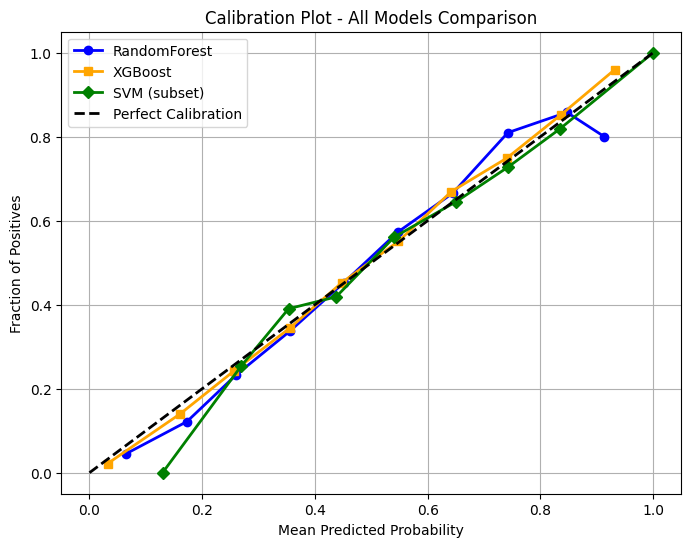

In [64]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))

model_info = {
    "RandomForest": {"color": "blue", "marker": "o"},
    "XGBoost": {"color": "orange", "marker": "s"},
    "SVM (subset)": {"color": "green", "marker": "D"}
}

# RandomForest + XGBoost (full test set)
for name in ["RandomForest", "XGBoost"]:
    model = trained_models[name]
    prob_pos = model.predict_proba(X_test_sel)[:,1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker=model_info[name]["marker"],
             color=model_info[name]["color"], linestyle='-', linewidth=2, markersize=6, label=name)

# SVM (subset)
prob_pos = svm_calibrated.predict_proba(X_test_svm)[:,1]
frac_pos, mean_pred = calibration_curve(y_test_svm, prob_pos, n_bins=10)
plt.plot(mean_pred, frac_pos, marker=model_info["SVM (subset)"]["marker"],
         color=model_info["SVM (subset)"]["color"], linestyle='-', linewidth=2, markersize=6, label="SVM (subset)")

# Perfect calibration line
plt.plot([0,1],[0,1],'k--',label='Perfect Calibration', linewidth=2)

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot - All Models Comparison")
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


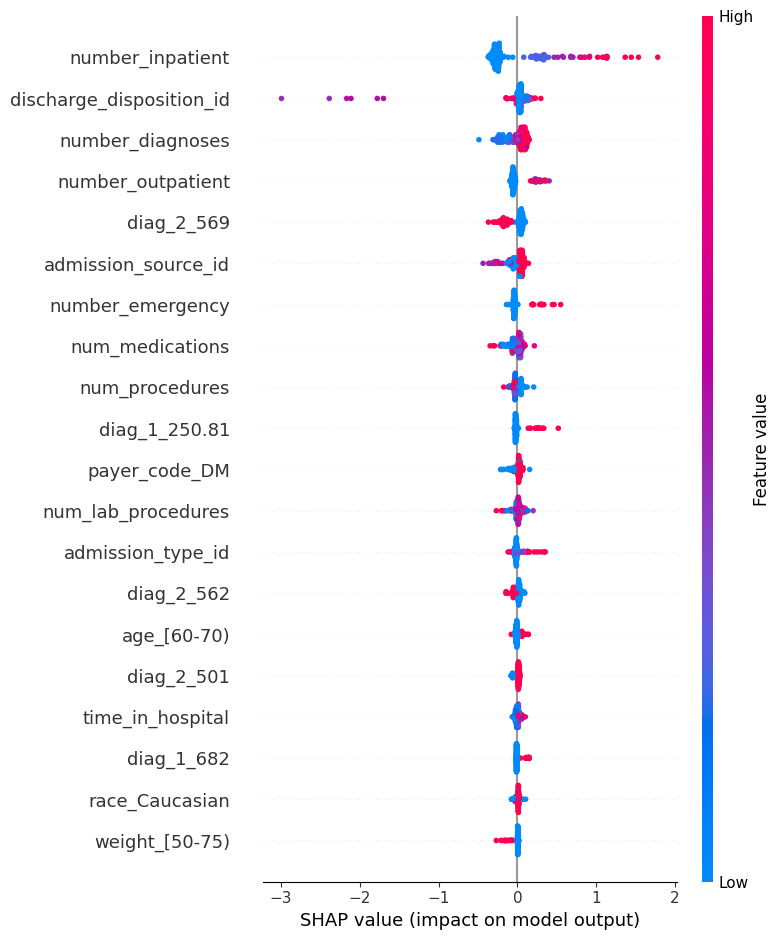

Top 15 Features Based on SHAP Values:


,Feature,MeanAbsSHAP,Impact
0,number_inpatient,0.345764,↓ Risk
1,discharge_disposition_id,0.118957,↓ Risk
2,number_diagnoses,0.094483,↑ Risk
3,number_outpatient,0.084440,↓ Risk
4,diag_2_569,0.081150,↓ Risk
5,admission_source_id,0.069714,↓ Risk
6,number_emergency,0.058432,↓ Risk
7,num_medications,0.052692,↓ Risk
8,num_procedures,0.041572,↑ Risk
9,diag_1_250.81,0.036707,↑ Risk


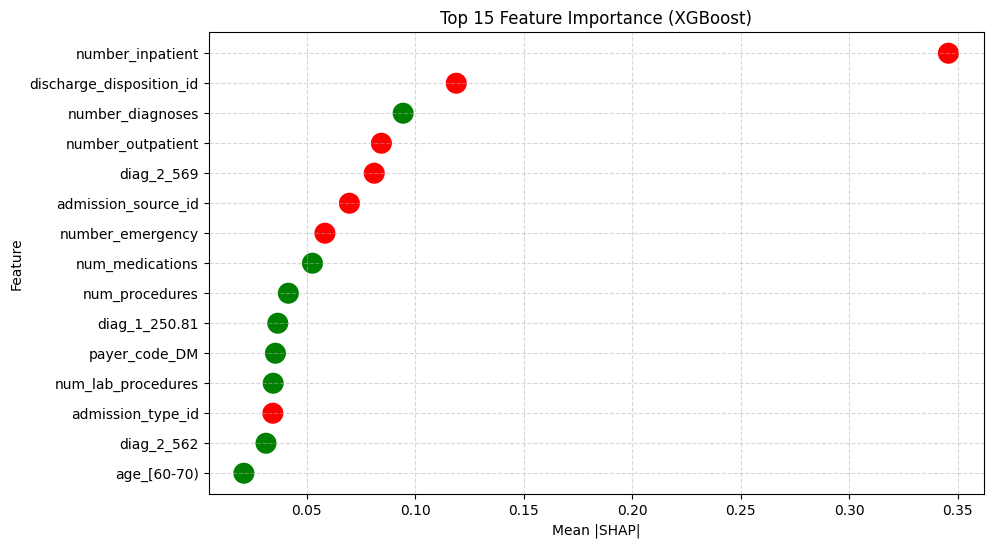

In [65]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get underlying XGBoost from CalibratedClassifierCV 
xgb_calibrated = trained_models["XGBoost"]
xgb_model = xgb_calibrated.estimator  # underlying XGBClassifier

# Subset data for SHAP (first 200 rows for speed) 
X_shap_dense = X_test_sel[:200].toarray() if hasattr(X_test_sel, "toarray") else X_test_sel[:200]

# SHAP explainer & values 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_shap_dense)
shap_array = shap_values.values[1] if isinstance(shap_values.values, list) else shap_values.values

# Generate feature names after preprocessing 
feature_names = list(num_cols)  # numeric features

# One-hot encoded categorical features
if "cat" in preprocessor.named_transformers_:
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feature_names += list(cat_feature_names)

# Ensure lengths match SHAP array
feature_names = feature_names[:shap_array.shape[1]]

# SHAP summary plot 
shap.summary_plot(shap_array, features=X_shap_dense, feature_names=feature_names)

# Top 15 feature table 
shap_abs_mean = np.abs(shap_array).mean(axis=0)
mean_shap = shap_array.mean(axis=0)

top_features = pd.DataFrame({
    "Feature": feature_names,
    "MeanAbsSHAP": shap_abs_mean,
    "Impact": np.where(mean_shap>0,"↑ Risk",
                       np.where(mean_shap<0,"↓ Risk","Neutral"))
}).sort_values("MeanAbsSHAP", ascending=False).head(15)

print("Top 15 Features Based on SHAP Values:")
display(top_features.reset_index(drop=True))

# Dot plot for top features 
colors = top_features["Impact"].map({"↑ Risk":"red","↓ Risk":"green","Neutral":"gray"})
top_features_sorted = top_features.sort_values("MeanAbsSHAP")
plt.figure(figsize=(10,6))
plt.scatter(top_features_sorted["MeanAbsSHAP"], top_features_sorted["Feature"], s=200, c=colors)
plt.xlabel("Mean |SHAP|")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importance (XGBoost)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
